In [1]:
import pyodbc # type: ignore
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

sqlServerName = 'DESKTOP-HNI1KAC\SQLEXPRESS'
databaseName = 'Finance'
trusted_connection = 'yes'
connenction_string = (f"DRIVER={{SQL Server}};"f"SERVER={sqlServerName};"f"DATABASE={databaseName};"f"Trusted_Connection={'yes'}")
try:
   conn = pyodbc.connect(connenction_string)
except pyodbc.Error as ex:
      print("An error occurred in SQL Server:", ex)

data = pd.read_sql(("SELECT * FROM dbo.Expenses;"), conn)
#print(data)


# Overview of Spending and Income

## Total Quarterly Spending and Income

In [2]:
QuarterlyTotalsQuery = """
SELECT 
    Type,
	DATEADD(MONTH, (DATEDIFF(MONTH, 0, Date) / 3) * 3, 0) AS IntervalStart,
    COUNT(*) AS Count,
    SUM(Amount) AS TotalAmount
FROM 
    dbo.Expenses
GROUP BY 
    DATEADD(MONTH, (DATEDIFF(MONTH, 0, Date) / 3) * 3, 0),
    Type
ORDER BY 
	Type,
    IntervalStart;
"""
qTotals = pd.read_sql(QuarterlyTotalsQuery,conn)

#Converts to date format without time (object data type).
qTotals['IntervalStart'] = qTotals['IntervalStart'].dt.date

In [3]:
#Formatting the above table to show income and expenses for each date range
# Creating a pivot table, date is currently the index 
pivot_qT = qTotals.pivot_table(index='IntervalStart', columns='Type', values='TotalAmount', aggfunc='sum', 
                               margins=True, margins_name='Total')

#pivot_qT.reset_index(inplace=True) # Reset index to keep IntervalStart as a column

pivot_qT

Type,Expense,Income,Total
IntervalStart,,,
2022-07-01,-2328.07,10850.47,8522.40
2022-10-01,-3626.07,12213.75,8587.68
2023-01-01,-4574.75,14525.08,9950.33
2023-04-01,-9123.18,13611.42,4488.24
2023-07-01,-6866.92,15366.84,8499.92
2023-10-01,-8328.09,12340.04,4011.95
2024-01-01,-10169.26,14513.69,4344.43
2024-04-01,-5477.68,12705.81,7228.13
2024-07-01,-3282.64,14873.02,11590.38


## Boxplots Weekly and Monthly Spending 

### Monthly Expenses

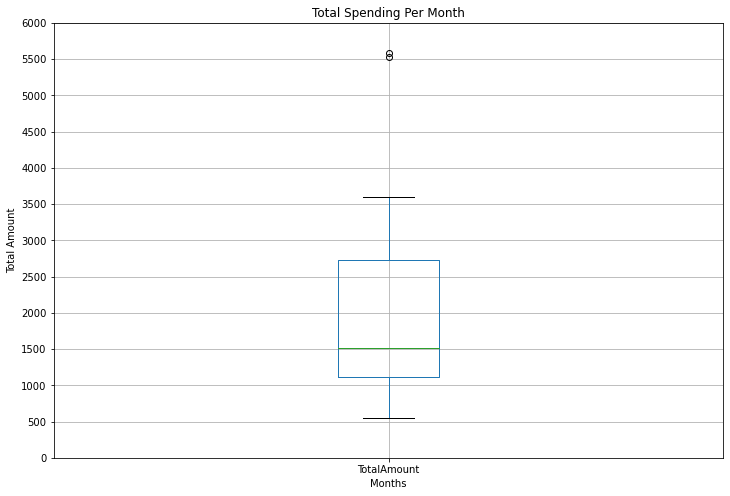

count      28.000000
mean     2051.852500
std      1351.704196
min       555.350000
25%      1114.397500
50%      1508.325000
75%      2730.027500
max      5582.790000
Name: TotalAmount, dtype: float64

In [26]:
monthlyTotalsQuery = """
SELECT 
    Type,
	DATEADD(MONTH, (DATEDIFF(MONTH, 0, Date)), 0) AS IntervalStart,
    SUM(Amount) AS TotalAmount
FROM 
    dbo.Expenses
GROUP BY 
    DATEADD(MONTH, (DATEDIFF(MONTH, 0, Date)), 0),
    Type
ORDER BY 
	Type,
    IntervalStart;
"""
mTotals = pd.read_sql(monthlyTotalsQuery,conn)

mTotals['TotalAmount'] = mTotals['TotalAmount'].abs() # Convert negative values to positive
mTotals_boxplot = mTotals[mTotals['Type'] != 'Income'] # Filter out rows where Type is income 
mTotals['IntervalStart'] = mTotals['IntervalStart'].dt.date #convert from date time to date

plt.figure(figsize=(12, 8)) 
mTotals_boxplot.boxplot(column='TotalAmount') 
plt.title('Total Spending Per Month') 
plt.suptitle('')
plt.xlabel('Months')
plt.ylabel('Total Amount') 
plt.yticks(range(0, int(mTotals_boxplot['TotalAmount'].max()) + 500, 500))# Set y-axis ticks 
plt.show()

# Calculate summary statistics 
summary_stats = mTotals_boxplot['TotalAmount'].describe() 
summary_stats

### Weekly Expenses 

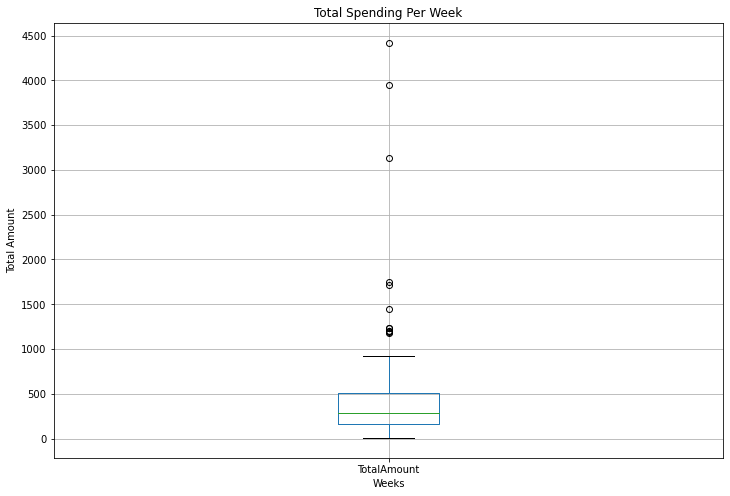

count     122.000000
mean      470.916967
std       639.261201
min         5.500000
25%       157.400000
50%       285.755000
75%       507.720000
max      4421.920000
Name: TotalAmount, dtype: float64

In [7]:
weeklyTotalsQuery = """
SELECT 
    Type,
    DATEADD(WEEK, DATEDIFF(WEEK, 0, Date), 0) AS IntervalStart,
    COUNT(*) AS Count,
    SUM(Amount) AS TotalAmount
FROM 
    dbo.Expenses
WHERE
    Type = 'Expense'
GROUP BY 
    DATEADD(WEEK, DATEDIFF(WEEK, 0, Date), 0),
    Type
ORDER BY 
    Type,
    IntervalStart;
"""
wTotals = pd.read_sql(weeklyTotalsQuery,conn)

wTotals['TotalAmount'] = wTotals['TotalAmount'].abs() # Convert negative values to positive

plt.figure(figsize=(12, 8)) 
wTotals.boxplot(column='TotalAmount') 
plt.title('Total Spending Per Week') 
plt.suptitle('')
plt.xlabel('Weeks')
plt.ylabel('Total Amount') 
plt.yticks(range(0, int(wTotals['TotalAmount'].max()) + 500, 500))# Set y-axis ticks 
plt.show()

# Calculate summary statistics 
summary_stats = wTotals['TotalAmount'].describe() 
summary_stats

# Progression of Expenses Across Time

## Comparison of Annual Weekly Expenses by Year

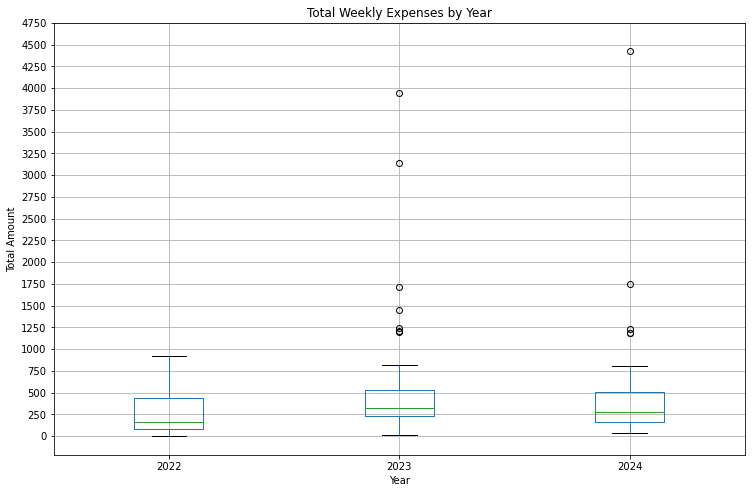

      count        mean         std   min     25%      50%       75%      max
Year                                                                         
2022   22.0  270.642727  246.960512   5.5   83.97  165.575  434.9400   922.42
2023   52.0  553.383462  703.712996  18.0  233.40  326.430  532.1475  3944.70
2024   48.0  473.370625  679.084317  33.9  162.45  272.530  502.9525  4421.92


In [8]:
#side by side boxplot comparison of weekly expenses 

# Extract the year from the StartDate
wTotals['Year'] = wTotals['IntervalStart'].dt.year

fig, ax = plt.subplots(figsize=(12, 8))
wTotals.boxplot(column='TotalAmount', by='Year', ax=ax)
plt.title('Total Weekly Expenses by Year')
plt.suptitle('')  # Remove the automatic suptitle
plt.xlabel('Year')
plt.ylabel('Total Amount')
plt.yticks(range(0, int(wTotals['TotalAmount'].max()) + 500, 250))# Set y-axis ticks 
plt.show()

# Calculate summary statistics 
summary_stats = wTotals.groupby('Year')['TotalAmount'].describe() 
print(summary_stats)

## Time Series plot of Monthly Expenses and Income

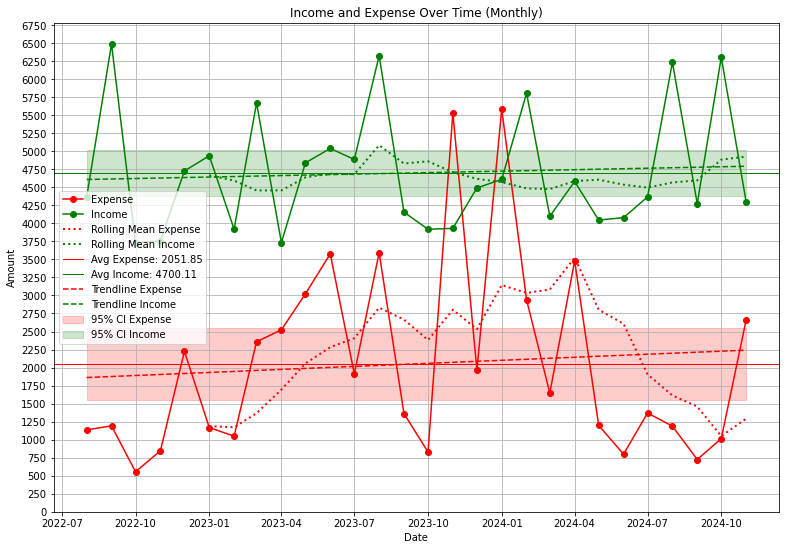

In [27]:
#includes, trendline, meanline, rolling mean, confidence interval

#create a pivot table for time series plot
pivot_mT = mTotals.pivot_table(index='IntervalStart', columns='Type', values='TotalAmount', aggfunc='sum', 
                               margins=True, margins_name='Total')

pivot_mT = pivot_mT.iloc[:-1, :-1] # Remove the 'Total' row and column for plotting 
pivot_mT['MonthInt'] = np.arange(1, len(pivot_mT) + 1) # encode months as integers for trendline

# Calculate the trendlines for Expense and income 
z_expense = np.polyfit(pivot_mT['MonthInt'], pivot_mT['Expense'], 1) 
p_expense = np.poly1d(z_expense) 
z_income = np.polyfit(pivot_mT['MonthInt'], pivot_mT['Income'], 1) 
p_income = np.poly1d(z_income)

# Calculate the rolling means
window_size = 6 
pivot_mT['Expense_RollingMean'] = pivot_mT['Expense'].rolling(window=window_size).mean()
pivot_mT['Income_RollingMean'] = pivot_mT['Income'].rolling(window=window_size).mean()

# mean for mean line
mean_expense = pivot_mT['Expense'].mean() 
mean_income = pivot_mT['Income'].mean()

# Calculate standard error for confidence interval shading 
std_error_expense = pivot_mT['Expense'].std() / np.sqrt(len(pivot_mT)) 
std_error_income = pivot_mT['Income'].std() / np.sqrt(len(pivot_mT)) 
z = 1.96 # Z-score for 95% confidence interval 
# Calculate confidence intervals 
ci_expense_lower = mean_expense - z * std_error_expense 
ci_expense_upper = mean_expense + z * std_error_expense 
ci_income_lower = mean_income - z * std_error_income 
ci_income_upper = mean_income + z * std_error_income

# Plot the data
plt.figure(figsize=(13, 9))
plt.plot(pivot_mT.index, pivot_mT['Expense'], label='Expense', marker='o', color='red')
plt.plot(pivot_mT.index, pivot_mT['Income'], label='Income', marker='o', color='green')

# Add rolling mean lines 
plt.plot(pivot_mT.index, pivot_mT['Expense_RollingMean'], color='red', linestyle='dotted', linewidth=2, label='Rolling Mean Expense')
plt.plot(pivot_mT.index, pivot_mT['Income_RollingMean'], color='green', linestyle='dotted', linewidth=2, label='Rolling Mean Income')

# Add mean lines 
plt.axhline(y=mean_expense, color='red', linestyle='solid', linewidth=1, label=f'Avg Expense: {mean_expense:.2f}') 
plt.axhline(y=mean_income, color='green', linestyle='solid', linewidth=1, label=f'Avg Income: {mean_income:.2f}')

# Add confidence interval shading 
plt.fill_between(pivot_mT.index, ci_expense_lower, ci_expense_upper, color='red', alpha=0.2, label='95% CI Expense') 
plt.fill_between(pivot_mT.index, ci_income_lower, ci_income_upper, color='green', alpha=0.2, label='95% CI Income')

# Add trendlines
plt.plot(pivot_mT.index, p_expense(pivot_mT['MonthInt']), "r--", label="Trendline Expense") 
plt.plot(pivot_mT.index, p_income(pivot_mT['MonthInt']), "g--", label="Trendline Income")

plt.title('Income and Expense Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.yticks(range(0, int(mTotals['TotalAmount'].max()) + 500, 250))# Set y-axis ticks 
plt.legend()
plt.grid(True)

plt.show()


In [53]:
# Print rolling mean values 
print("Rolling Mean for Expenses:") 
print(pivot_mT['Expense_RollingMean'].iloc[::6]) 
print("\nRolling Mean for Income:") 
print(pivot_mT['Income_RollingMean'].iloc[::5])

Rolling Mean for Expenses:
IntervalStart
2022-08-01            NaN
2023-02-01    1172.465000
2023-08-01    2831.123333
2024-02-01    3035.280000
2024-08-01    1613.681667
Name: Expense_RollingMean, dtype: float64

Rolling Mean for Income:
IntervalStart
2022-08-01            NaN
2023-01-01    4666.800000
2023-06-01    4689.416667
2023-11-01    4709.088333
2024-04-01    4586.120000
2024-09-01    4596.471667
Name: Income_RollingMean, dtype: float64


### Rate of Spending Increase

In [32]:
# Extracting the rate of increase (slope) from the trendline coefficients 
expense_rate_of_increase = z_expense[0] 
income_rate_of_increase = z_income[0] 
print(f"The rate of increase for expenses is {expense_rate_of_increase:.2f} per month.") 
print(f"The rate of increase for income is {income_rate_of_increase:.2f} per month.")

The rate of increase for expenses is 14.05 per month.
The rate of increase for income is 6.79 per month.


In [30]:
expense_rate_of_increase = z_expense[0] 
expense_intercept = z_expense[1] 
income_rate_of_increase = z_income[0] 
income_intercept = z_income[1]
print(f"The trendline formula for expenses is: Expense = {expense_rate_of_increase:.2f} * Date + {expense_intercept:.2f}") 
print(f"The trendline formula for income is: Income = {income_rate_of_increase:.2f} * Date + {income_intercept:.2f}")

The trendline formula for expenses is: Expense = 14.05 * Date + 1848.17
The trendline formula for income is: Income = 6.79 * Date + 4601.60


### Weekly Average Spending per Quarter

In [8]:
#Weekly average spending per quarter
weeklyAveragesQuery = """
WITH DaysInMonth AS (
    SELECT 
        DISTINCT DATEPART(year, Date) AS Year, 
        DATEPART(month, Date) AS Month, 
        DAY(EOMONTH(Date)) AS DaysInMonth 
    FROM 
        dbo.Expenses
),
MonthlySpending AS (
    SELECT 
        DATEPART(year, Date) AS Year, 
        DATEPART(month, Date) AS Month, 
        SUM(Amount) AS MonthlyTotal 
    FROM 
        dbo.Expenses 
    WHERE 
        Type = 'Expense' 
    GROUP BY 
        DATEPART(year, Date), 
        DATEPART(month, Date)
),
QuarterlySpending AS (
    SELECT 
        ms.Year,
        (ms.Month - 1) / 3 + 1 AS Quarter,
        SUM(MonthlyTotal) AS QuarterlyTotal,
        SUM(DaysInMonth) AS DaysInQuarter
    FROM 
        MonthlySpending ms
    JOIN 
        DaysInMonth dim ON ms.Year = dim.Year AND ms.Month = dim.Month 
    GROUP BY 
        ms.Year, 
        (ms.Month - 1) / 3 + 1
)
SELECT 
    Year, 
    Quarter,
    CAST(QuarterlyTotal / (DaysInQuarter / 7.0) AS Decimal(16,2)) AS WeeklyAverage 
FROM 
    QuarterlySpending 
ORDER BY 
    Year, 
    Quarter;
"""
wAverages = pd.read_sql(weeklyAveragesQuery,conn)
wAverages

,Year,Quarter,WeeklyAverage
0,2022,3,-267.16
1,2022,4,-275.90
2,2023,1,-355.81
3,2023,2,-701.78
4,2023,3,-522.48
5,2023,4,-633.66
6,2024,1,-782.25
7,2024,2,-421.36
8,2024,3,-249.77
9,2024,4,-421.75


### Weekly Average Spending per Month - Side By Side Boxplot (include summary table)

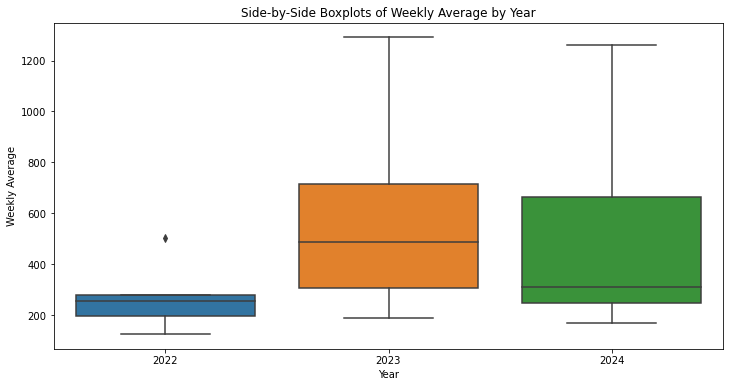

In [16]:
#Weekly average spending per month
weeklyAveragesQuery = """
WITH DaysInMonth AS (
    SELECT 
		DISTINCT DATEPART(year, Date) AS Year, 
		DATEPART(month, Date) AS Month, 
		DAY(EOMONTH(Date)) AS DaysInMonth 
	FROM 
		dbo.Expenses
),
MonthlySpending AS (
    SELECT 
		DATEPART(year, Date) AS Year, 
		DATEPART(month, Date) AS Month, 
		SUM(Amount) AS MonthlyTotal 
	FROM 
		dbo.Expenses 
	WHERE 
		Type = 'Expense' 
	GROUP BY 
		DATEPART(year, Date), 
		DATEPART(month, Date)
)
SELECT 
	ms.Year, 
	ms.Month, 
	CAST(ms.MonthlyTotal / (dim.DaysInMonth / 7.0) AS Decimal(16,2)) AS WeeklyAverage 
	FROM 
		MonthlySpending ms 
	JOIN 
		DaysInMonth dim ON ms.Year = dim.Year AND ms.Month = dim.Month 
	ORDER BY 
		ms.Year, 
		ms.Month;
"""
wAverages = pd.read_sql(weeklyAveragesQuery,conn)
# Convert negative values to positive
wAverages['WeeklyAverage'] = wAverages['WeeklyAverage'].abs()
#wAverages

import seaborn as sns

# Create side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='WeeklyAverage', data=wAverages)
plt.title('Side-by-Side Boxplots of Weekly Average by Year')
plt.xlabel('Year')
plt.ylabel('Weekly Average')
plt.show()

# Savings

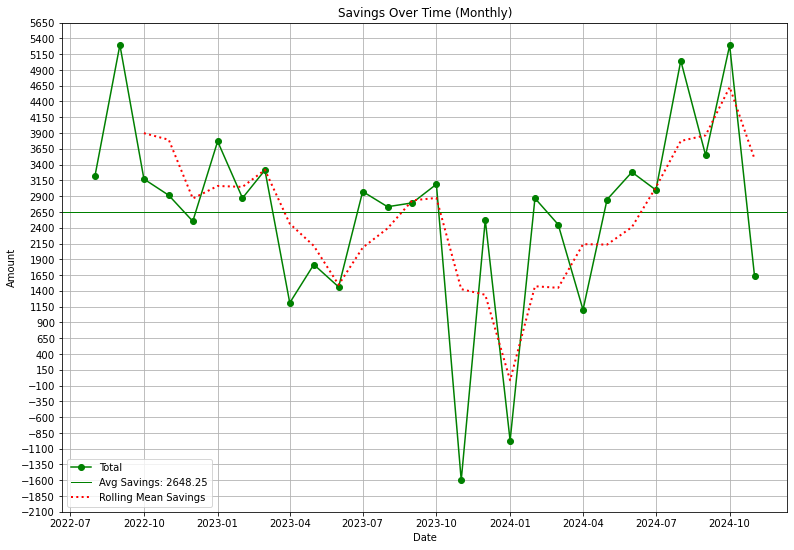

In [54]:
#same pivot creation as quarterly totals
pivot_mT = mTotals.pivot_table(index='IntervalStart', columns='Type', values='TotalAmount', aggfunc='sum', 
                               margins=True, margins_name='Savings')

# Remove the bottom total savings row for plotting 
pivot_mT = pivot_mT[:-1]

# Plot the data
plt.figure(figsize=(13, 9))
plt.plot(pivot_mT.index, pivot_mT['Savings'], label='Total', marker='o', color='green')

# Add mean line 
mean_savings = pivot_mT['Savings'].mean()
plt.axhline(y=mean_savings, color='green', linestyle='solid', linewidth=1, label=f'Avg Savings: {mean_savings:.2f}')

# Calculate the rolling means
window_size = 3
pivot_mT['Savings_RollingMean'] = pivot_mT['Savings'].rolling(window=window_size).mean()

# Add rolling mean lines 
plt.plot(pivot_mT.index, pivot_mT['Savings_RollingMean'], color='red', linestyle='dotted', linewidth=2, label='Rolling Mean Savings')

plt.title('Savings Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.yticks(range(int(pivot_mT['Savings'].min()) - 500, int(pivot_mT['Savings'].max()) + 500, 250))# Set y-axis ticks 
plt.legend()
plt.grid(True)

plt.show()

In [55]:
# Print rolling mean values 
print("Rolling Mean for Savings:") 
print(pivot_mT['Savings_RollingMean'].iloc[::3]) 

Rolling Mean for Savings:
IntervalStart
2022-08-01            NaN
2022-11-01    3793.830000
2023-02-01    3046.816667
2023-05-01    2112.893333
2023-08-01    2389.320000
2023-11-01    1427.126667
2024-02-01    1472.783333
2024-05-01    2132.673333
2024-08-01    3774.526667
2024-11-01    3491.676667
Name: Savings_RollingMean, dtype: float64


## Weekly savings

## Category Breakdown

In [6]:
catBreakdownQuery = """
SELECT Category, SUM(Amount) AS Total, (SUM(Amount) * 100.0 / (SELECT SUM(Amount) FROM dbo.Expenses WHERE Amount < 0)) AS PercentageOfTotal
FROM dbo.Expenses
WHERE Amount < 0
GROUP BY Category
ORDER BY Total ASC;
"""
catbreak = pd.read_sql(catBreakdownQuery,conn)
#catbreak

# Convert negative values to positive for pareto chart
catbreak['Total'] = catbreak['Total'].abs()
# Sort by totals in descending order 
catbreak = catbreak.sort_values(by='Total', ascending=False) 
# Calculate cumulative percentage 
catbreak['CumulativePercentage'] = catbreak['PercentageOfTotal'].cumsum()


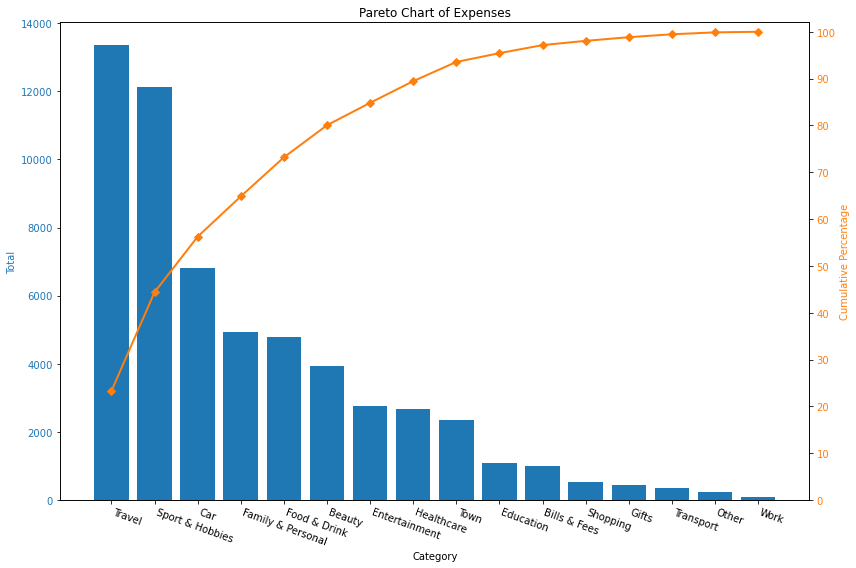

In [7]:
# Plot the Pareto chart
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for TotalAmount
ax1.bar(catbreak['Category'], catbreak['Total'], color='C0')
ax1.set_xlabel('Category')
ax1.set_ylabel('Total', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.xticks(rotation=-20, ha='left') #rotate cat labels so they dont overlap

# Line chart for CumulativePercentage on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(catbreak['Category'], catbreak['CumulativePercentage'], color='C1', marker='D', linestyle='-', linewidth=2)
ax2.set_ylabel('Cumulative Percentage', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0,102) # Set bottom limit to 0 to make gaps equivalent

# Set custom ticks for the cumulative percentage axis
ax2.set_yticks(range(0, 101, 10))

plt.title('Pareto Chart of Expenses')
fig.tight_layout()
plt.show()


## Subcategory Breakdown

In [8]:
subcatBreakdownQuery = """
SELECT Category, Subcategory, SUM(Amount) as Total
FROM dbo.Expenses 
WHERE Amount < 0 
GROUP BY Category,Subcategory 
ORDER BY Category,Total ASC;
"""
subcatbreak = pd.read_sql(subcatBreakdownQuery,conn)
subcatbreak['Total'] = subcatbreak['Total'].abs() #make values positve for the treemap 

subcatbreak

,Category,Subcategory,Total
0,Beauty,irregular,1508.25
1,Beauty,skin,1205.84
2,Beauty,haircut,622.35
3,Beauty,dentist,400.00
4,Beauty,Pilot,205.00
5,Bills & Fees,phone plan,490.00
6,Bills & Fees,Tax,374.00
7,Bills & Fees,subscriptions,123.90
8,Car,Fuel,3867.72
9,Car,Payments,2213.20


In [13]:
import plotly.express as px

fig = px.treemap(subcatbreak, path=['Category', 'Subcategory'], values='Total', 
                 title='Spending by Category and Subcategory')
fig.update_traces(textinfo='label+value')
fig.update_layout(width=1200, height=900)
#fig.write_html('first_figure.html', auto_open=True)
fig.show()

In [1]:
# Pivot data for hierarchical bar chart
#pivot_scB = subcatbreak.pivot(index='Category', columns='Subcategory', values='Total')

# Plot hierarchical bar chart
#pivot_scB.plot(kind='bar', stacked=True)

#plt.title('Spending by Category and Subcategory')
#plt.xlabel('Category')
#plt.ylabel('Amount')
#plt.legend(title='Subcategory')
#plt.show()


In [56]:
# Close the connection
#if 'connection' in locals():
conn.close()